## Imports and Inputs

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta, timezone

from dune_client.client import DuneClient
from config import key

/tmp/ipykernel_640/2591426926.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# import json of covers from dune api 
dune = DuneClient(key)
covers_list_result = dune.get_latest_result_dataframe(2303588)

In [3]:
# coingecko ETH Market Chart API for ETH-USD for last year
url = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart'
eth_price_params = {'vs_currency': 'usd', 
                   'days': '365',
                   'interval': 'daily'}
eth_usd_prices = requests.get(url, params=eth_price_params).json()['prices']

# create a dataframe with an index of dates and the corresponding ETH prices
price_df = pd.DataFrame(eth_usd_prices, columns = ['Date', 'EthUsd'])
price_df['Date'] = pd.to_datetime(price_df['Date'], utc=True, unit='ms', origin='unix')
price_df.set_index('Date', inplace=True)

## Covers Table Processing

In [4]:
# process covers dataframe and select only current and 11 previous months 
df_covers = covers_list_result

# change timestamp to datetime format and normalise all dates to midnight
df_covers['cover_start_time'] = pd.to_datetime(df_covers['cover_start_time']).dt.floor('D')

# add ETHUSD prices daily
df_covers = df_covers.join(price_df, on='cover_start_time')

# add premium cost in ETH, dividing dollar prices by the ETH value
df_covers['premium_eth'] = df_covers['premium_dollar'] / df_covers['EthUsd']

# cut off from 11 months from start of current month
month = datetime.now().month
year = datetime.now().year
df_covers_sold_last_year = df_covers[df_covers['cover_start_time'] >= datetime(year-1, month+1, 1, tzinfo=timezone.utc)]

# create month and quarter columns
df_covers_sold_last_year['cover_start_month'] = df_covers_sold_last_year['cover_start_time'].dt.to_period('M')
df_covers_sold_last_year['cover_start_quarter'] = df_covers_sold_last_year['cover_start_time'].dt.to_period('Q')

/tmp/ipykernel_640/3565940988.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_covers_sold_last_year['cover_start_month'] = df_covers_sold_last_year['cover_start_time'].dt.to_period('M')
/tmp/ipykernel_640/3565940988.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covers_sold_last_year['cover_start_month'] = df_covers_sold_last_year['cover_start_time'].dt.to_period('M')
/tmp/ipykernel_640/3565940988.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_covers_sold_last_year['cover_start_quarter'] = df_covers_sold_last_year['cover_start_time'].dt.to_period('Q')
/tmp/ipykernel_640/3565940988.py:20: SettingWithCopyWarning: 
A value is try

## Monthly Premiums

### USD

cover_start_month
2023-05    117050.226009
2023-06     98451.461209
2023-07    100200.112048
2023-08     60252.365325
2023-09     53268.365017
2023-10     71195.029632
2023-11     83899.202893
2023-12     54813.380012
2024-01     70710.289325
2024-02    108962.033431
2024-03    370050.959036
2024-04    677713.157374
Freq: M, Name: premium_dollar, dtype: float64

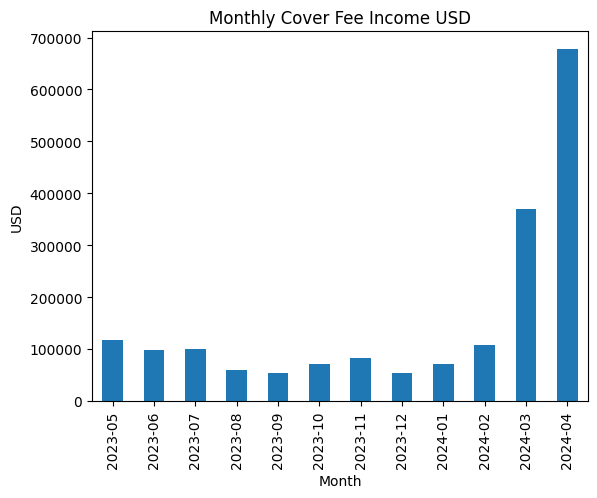

In [7]:
monthly_cover_fees_usd = df_covers_sold_last_year.groupby(by='cover_start_month')['premium_dollar'].sum()
display(monthly_cover_fees_usd)
monthly_cover_fees_usd.plot(kind='bar', ylabel='USD', xlabel='Month', title='Monthly Cover Fee Income USD');

### ETH

cover_start_month
2023-05     63.549741
2023-06     55.703824
2023-07     52.681060
2023-08     34.419139
2023-09     32.707593
2023-10     43.432369
2023-11     44.010508
2023-12     24.067198
2024-01     30.480285
2024-02     42.014428
2024-03    104.085016
2024-04    201.799085
Freq: M, Name: premium_eth, dtype: float64

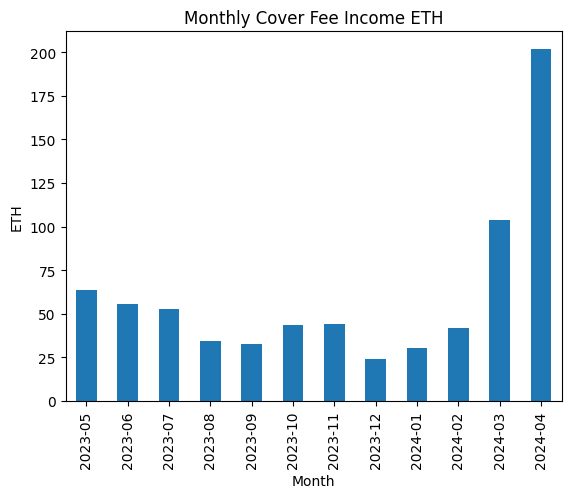

In [8]:
monthly_cover_fees_eth = df_covers_sold_last_year.groupby(by='cover_start_month')['premium_eth'].sum()
display(monthly_cover_fees_eth)
monthly_cover_fees_eth.plot(kind='bar', ylabel='ETH', xlabel='Month', title='Monthly Cover Fee Income ETH');

## Quarterly Premiums

### USD

cover_start_quarter
2023Q2    215501.687218
2023Q3    213720.842390
2023Q4    209907.612537
2024Q1    549723.281792
2024Q2    677713.157374
Freq: Q-DEC, Name: premium_dollar, dtype: float64

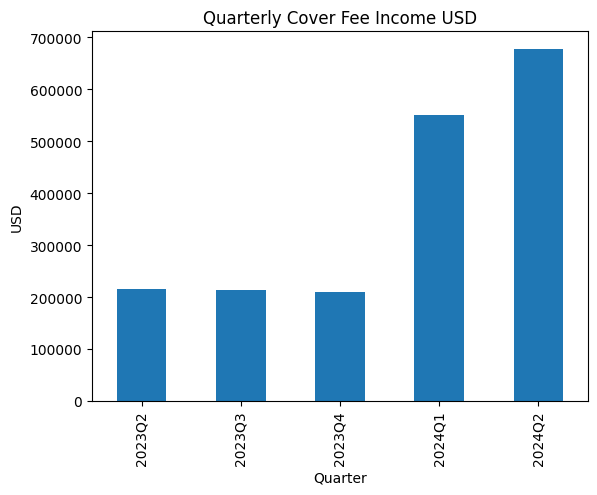

In [9]:
quarterly_cover_fees_usd = df_covers_sold_last_year.groupby(by='cover_start_quarter')['premium_dollar'].sum()
display(quarterly_cover_fees_usd)
quarterly_cover_fees_usd.plot(kind='bar', ylabel='USD', xlabel='Quarter', title='Quarterly Cover Fee Income USD');

### ETH

cover_start_quarter
2023Q2    119.253565
2023Q3    119.807792
2023Q4    111.510075
2024Q1    176.579729
2024Q2    201.799085
Freq: Q-DEC, Name: premium_eth, dtype: float64

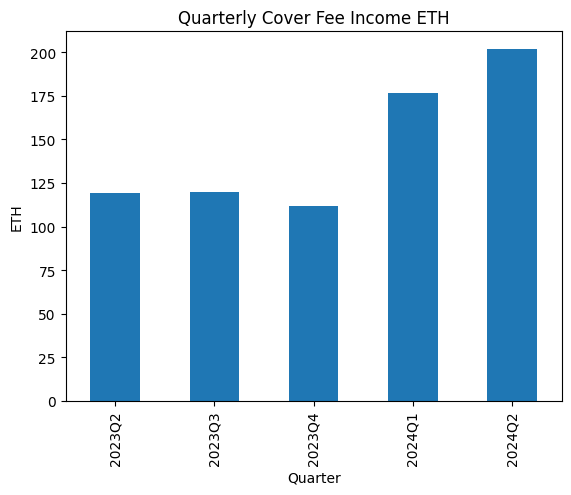

In [10]:
quarterly_cover_fees_eth = df_covers_sold_last_year.groupby(by='cover_start_quarter')['premium_eth'].sum()
display(quarterly_cover_fees_eth)
quarterly_cover_fees_eth.plot(kind='bar', ylabel='ETH', xlabel='Quarter', title='Quarterly Cover Fee Income ETH');

## Covers Bought

### Monhtly

cover_start_month
2023-05     39
2023-06     34
2023-07     36
2023-08     31
2023-09     61
2023-10     29
2023-11     35
2023-12     49
2024-01     60
2024-02     47
2024-03     92
2024-04    111
Freq: M, Name: cover_id, dtype: int64

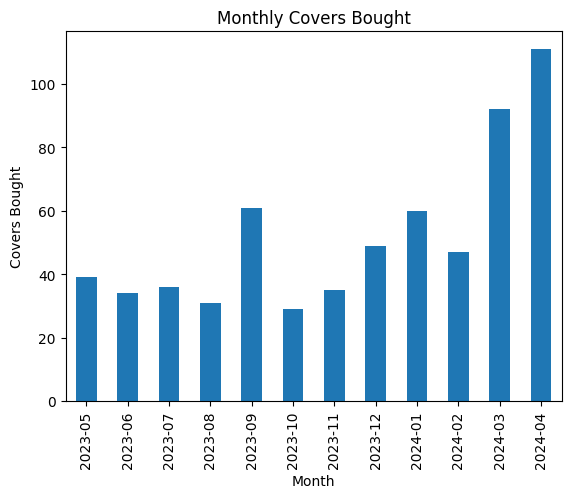

In [11]:
monthly_cover_count = df_covers_sold_last_year.groupby(by='cover_start_month')['cover_id'].nunique()
display(monthly_cover_count)
monthly_cover_count.plot(kind='bar', ylabel='Covers Bought', xlabel='Month', title='Monthly Covers Bought');

### Quarterly

cover_start_quarter
2023Q2     73
2023Q3    128
2023Q4    113
2024Q1    199
2024Q2    111
Freq: Q-DEC, Name: cover_id, dtype: int64

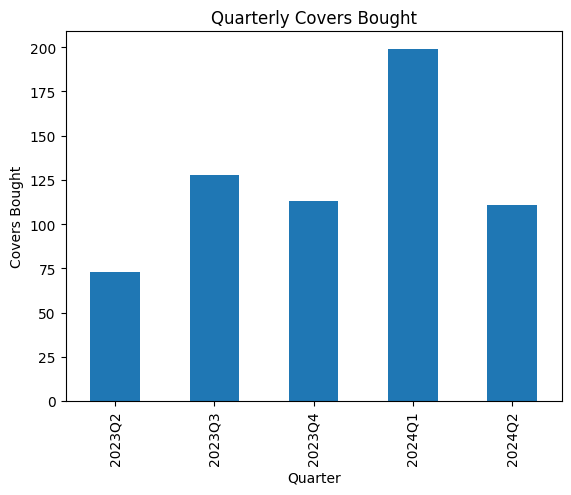

In [12]:
quarterly_cover_count = df_covers_sold_last_year.groupby(by='cover_start_quarter')['cover_id'].nunique()
display(quarterly_cover_count)
quarterly_cover_count.plot(kind='bar', ylabel='Covers Bought', xlabel='Quarter', title='Quarterly Covers Bought');

In [14]:
# work out cover fees denominated in ETH, allowing for 15% commission
commission_share = 0.15

monthly_cover_fees_usd = df_covers_30_days['premium_dollar'].sum()
monthly_cover_fees_after_commission = monthly_cover_fees_usd * (1 - commission_share)
monthly_commission = monthly_cover_fees_usd * commission_share

monthly_cover_fees_eth = monthly_cover_fees_usd / eth_usd
monthly_cover_fees_eth

39.58797846624159